This is going to be the similar mass case with circular orbit and then implement Df equation with that


How this Jupyter Notebook will look like:
- Initialize the packets
- initial conditions
- dictate the circular orbit
- forloop
- effective energy plot (coming soon)

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

In [325]:
plt.rcParams['font.family'] = 'Times New Roman'
#this is to make the font of the plots to be Times New Roman

In [326]:
const.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

This is the tests that were done in Kris' github:

In [327]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc

print(r_eff)

2817.2281287632354 pc


In [328]:
m1 = 4e8 * u.Msun

rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = (((rb/r_eff)**3)*r_eff).to(u.pc)
print(dyn_hard)

Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


This is going to be the initial conditions

In [329]:
plt.rcParams['font.family'] = 'Times New Roman'
# region Code Snippet 1: IC's
G = const.G #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A 
m2=4e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
#r_i has a separation of 430 pc
sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays
r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis 
a = (0.5 * (sep))
print (a)

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
# orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source


#V_i
v1_initial=[-72,102, 0] *u.km/u.s
v2_inital=[72,-102,0] *u.km/u.s #km/s

#To arrays
v1=np.array(v1_initial,dtype="float64") *u.km/u.s
v2=np.array(v2_inital,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

r = np.sqrt((r2[0] - r1[0])** 2 + (r2[1] - r1[1])** 2 + (r2[2] - r1[2])** 2)

# endregion

print(v1, v2)

215.0 pc
[-72. 102.   0.] km / s [  72. -102.    0.] km / s


Dynamical Friction and adding them as each component:

In [330]:
# region Code Snippet 2: DF
r1_com = r1 - r_com
r2_com = r2 - r_com

r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
 # region code : Semi Major Axes
#redacted the a becuase r = a in circular orbits
# rmax1 = np.max(r1 - r_com)
# rmin1 = np.min(r1 - r_com)
# a1 = (rmax1+rmin1)/2

# rmax2 = np.max(r2 - r_com)
# rmin2 = np.min(r2 - r_com)
# a2 = (rmax2+rmin2)/2
# endregion

o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
# region code : Coulomb Logarithm
x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
# endregion
# region code : Dynamical Friction

F_D1 = 0.428 * ln_A1 * (G * m1**2 / r1_com**2)
F_D2 = 0.428 * ln_A2 * (G * m2**2 / r2_com**2)

print("Dynamical Friction Forces:", F_D1, F_D2)

# Relative velocities
v_r1 = v1 - v_com
v_r2 = v2 - v_com

# Unit vectors of relative velocities
v_rel_unit1 = v_r1 / np.linalg.norm(v_r1)
v_rel_unit2 = v_r2 / np.linalg.norm(v_r2)

# Dynamical friction force vectors (negative to the velocity vector)
F_D1_vector = -F_D1 * v_rel_unit1
F_D2_vector = -F_D2 * v_rel_unit2

# Convert to desired units
F_D1_vector = F_D1_vector.to((u.kg * u.m) / (u.s**2))
F_D2_vector = F_D2_vector.to((u.kg * u.m) / (u.s**2))

print("Dynamical Friction Force Vectors:", F_D1_vector, F_D2_vector)

# Convert to acceleration
a_D1 = (F_D1_vector / m1).to(u.km / u.s**2)
a_D2 = (F_D2_vector / m2).to(u.km / u.s**2)
print("Dynamical Friction Acceleration:", a_D1, a_D2)





Dynamical Friction Forces: 2.699863947836807e+62 m3 kg / (pc2 s2) 2.699863947836807e+62 m3 kg / (pc2 s2)
Dynamical Friction Force Vectors: [ 1.63522714e+29 -2.31657178e+29 -0.00000000e+00] kg m / s2 [-1.63522714e+29  2.31657178e+29 -0.00000000e+00] kg m / s2
Dynamical Friction Acceleration: [ 2.05594828e-13 -2.91259340e-13 -0.00000000e+00] km / s2 [-2.05594828e-13  2.91259340e-13 -0.00000000e+00] km / s2


In [331]:
massterm = (m1+m2)/(10**8*u.Msun)
velterm = ((200*u.km/u.s)/o)**2
dynhard_rad = (10*u.pc*massterm*velterm).to(u.pc)
print(dynhard_rad)

81.5361082035837 pc


In [332]:
coulomb_log_ = np.log10((a*o**2/(const.G*m1)).to(''))
print(coulomb_log_)
prefactor = 19./coulomb_log_
aterm = (a/(5.*u.kpc))**2
vterm = o/(200*u.km/u.s)
mterm = (10**8*u.Msun/(m1))
dyntime = (prefactor*aterm*vterm*mterm*u.Gyr).to(u.Myr)
print(dyntime)
print(np.sqrt(2)* o)


0.6906173797913483
12.596880855045313 Myr
280.1657214412427 km / s


did all the checks that would dictate when they become a hard binary

In [333]:
T = 17 * u.Myr #Total time of simulation
N = 500
delta_t = T/ N
print(delta_t.to(u.yr))

time_span=np.linspace(0, T, N) #Work on this with Kris' link

34000.0 yr


In [334]:
c = 1

Period Test

In [335]:
orbital_period = np.sqrt((4 * (np.pi)**2 / (G * (m1)) * (a**3))).to(u.Myr)

print(orbital_period)

14.766364899677814 Myr


orbital period / dyntime

In [336]:
dyntime / orbital_period

<Quantity 0.85307934>

put in function; reset local variables once used; keplers third law ( how many orbts to expect) = easiest version of the question

In [337]:

# def compute_distance_from_com(r, r_com):
#     r_com = r - r_com
#     return np.sqrt(r_com[0]**2 + r_com[1]**2 + r_com[2]**2)

# def coulomb_logarithm(r_com, o, m):
#     x = (np.abs(r_com.to(u.km)) * o**2) / (G * m)
#     return math.log10(x.to_value(u.dimensionless_unscaled))

# def dynamical_friction(m, r_com, ln_A):
#     return 0.428 * ln_A * (G * m**2 / r_com**2)

# def relative_velocity_unit_vector(v, v_com):
#     v_r = v - v_com
#     return v_r / np.linalg.norm(v_r)

# def dynamical_friction_force_vector(F_D, v_rel_unit):
#     return -F_D * v_rel_unit

# def dynamical_friction_acceleration(F_D_vector, m):
#     return (F_D_vector / m).to(u.km / u.s**2)

# def gravitational_force(r1, r2, m1, m2):
#     r = np.sqrt(np.sum((r2 - r1)**2))
#     force = G * m1 * m2 / r**3
#     return force

# def update_velocities(v1, v2, delta_t, F_D1, F_D2, r1, r2, r_com, m1, m2, m_gal, v_com):

#     dv1bydt = gravitational_force(r1, r2, m2, m1) + (c * a_D1)
#     dv2bydt = -gravitational_force(r1, r2, m1, m2) + (c * a_D2)

#     v1 += dv1bydt * delta_t
#     v2 += dv2bydt * delta_t


#     r1 += v1.to(u.pc / u.s) * delta_t
#     r2 += v2.to(u.pc / u.s) * delta_t

#     return v1, v2, r1, r2

# def compute_dynamical_friction(r1, r2, r_com, m1, m2, m_gal, v1, v2, v_com):

#     r1_com = compute_distance_from_com(r1, r_com)
#     r2_com = compute_distance_from_com(r2, r_com)


#     o = ((10**(2.2969)) * (m_gal / (10**(11) * u.M_sun))**(0.299)) * (u.km/u.s)
#     ln_A1 = coulomb_logarithm(r1_com, o, m1)
#     ln_A2 = coulomb_logarithm(r2_com, o, m2)


#     F_D1 = dynamical_friction(m1, r1_com, ln_A1)
#     F_D2 = dynamical_friction(m2, r2_com, ln_A2)


#     v_rel_unit1 = relative_velocity_unit_vector(v1, v_com)
#     v_rel_unit2 = relative_velocity_unit_vector(v2, v_com)


#     F_D1_vector = dynamical_friction_force_vector(F_D1, v_rel_unit1)
#     F_D2_vector = dynamical_friction_force_vector(F_D2, v_rel_unit2)


#     F_D1_vector = F_D1_vector.to((u.kg * u.m) / (u.s**2))
#     F_D2_vector = F_D2_vector.to((u.kg * u.m) / (u.s**2))


#     a_D1 = dynamical_friction_acceleration(F_D1_vector, m1)
#     a_D2 = dynamical_friction_acceleration(F_D2_vector, m2)

#     return a_D1, a_D2, F_D1, F_D2
# v1, v2, r1, r2 = update_velocities(v1, v2, delta_t, 0, 0, r1, r2, r_com, m1, m2, m_gal, v_com)


# a_D1, a_D2, F_D1, F_D2 = compute_dynamical_friction(r1, r2, r_com, m1, m2, m_gal, v1, v2, v_com)


# print("Updated velocities:", v1, v2)
# print("Updated positions:", r1, r2)
# print("Dynamical friction accelerations:", a_D1, a_D2)

[[ 2.09509967e-13 -2.95473996e-13 -0.00000000e+00]
 [ 2.13446669e-13 -2.99677016e-13 -0.00000000e+00]
 [ 2.17399347e-13 -3.03860337e-13 -0.00000000e+00]
 ...
 [ 5.46217528e-13 -5.00713425e-13 -0.00000000e+00]
 [-5.60530699e-13  4.84898136e-13 -0.00000000e+00]
 [-6.06769498e-13  4.25685412e-13 -0.00000000e+00]] [[-2.09509967e-13  2.95473996e-13 -0.00000000e+00]
 [-2.13446669e-13  2.99677016e-13 -0.00000000e+00]
 [-2.17399347e-13  3.03860337e-13 -0.00000000e+00]
 ...
 [-5.46217528e-13  5.00713425e-13 -0.00000000e+00]
 [ 5.60530699e-13 -4.84898136e-13 -0.00000000e+00]
 [ 6.06769498e-13 -4.25685412e-13 -0.00000000e+00]]


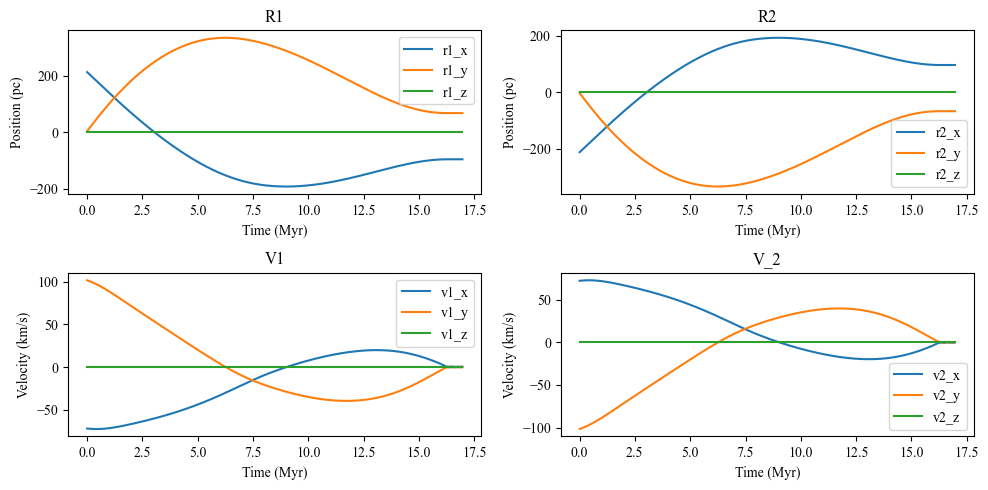

In [338]:
# region code : past for loop
r1_sol = []
r2_sol = []
v1_sol = []
v2_sol = []
F_D1sol = []
F_D2sol = []
F_force1 = []
F_force2 = []



for i in range(N):
    dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (c * a_D1)
    dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (c * a_D2) 
    v1 += dv1bydt * delta_t
    v2 += dv2bydt * delta_t

    r1 += v1.to(u.pc / u.s) * delta_t
    r2 += v2.to(u.pc / u.s) * delta_t
    # region Code Snippet 2: DF
    r1_com = r1 - r_com
    r2_com = r2 - r_com

    r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
    r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
   
    o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
    # region code : Coulomb Logarithm
    x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
    x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
    ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
    ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
    # endregion


    F_D1 = 0.428 * ln_A1 * (G * m1**2 / r1_com**2)
    F_D2 = 0.428 * ln_A2 * (G * m2**2 / r2_com**2)



    # Relative velocities
    v_r1 = v1 - v_com
    v_r2 = v2 - v_com

    # Unit vectors of relative velocities
    v_rel_unit1 = v_r1 / np.linalg.norm(v_r1)
    v_rel_unit2 = v_r2 / np.linalg.norm(v_r2)

    # Dynamical friction force vectors (negative to the velocity vector)
    F_D1_vector = -F_D1 * v_rel_unit1
    F_D2_vector = -F_D2 * v_rel_unit2

    # Convert to desired units
    F_D1_vector = F_D1_vector.to((u.kg * u.m) / (u.s**2))
    F_D2_vector = F_D2_vector.to((u.kg * u.m) / (u.s**2))



    # Convert to acceleration
    a_D1 = (F_D1_vector / m1).to(u.km / u.s**2)
    a_D2 = (F_D2_vector / m2).to(u.km / u.s**2)



    # Append results to lists (if needed)
    F_force1.append(F_D1_vector.to(u.kg * u.m / u.s**2))
    F_force2.append(F_D2_vector.to(u.kg * u.m / u.s**2))
    F_D1sol.append([a_D1[0].value, a_D1[1].value, a_D1[2].value])
    F_D2sol.append([a_D2[0].value, a_D2[1].value, a_D2[2].value])

    r1_sol.append(r1.copy())
    r2_sol.append(r2.copy())
    v1_sol.append(v1.copy())
    v2_sol.append(v2.copy())


time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit


r1_sol = np.array(r1_sol)  
r2_sol = np.array(r2_sol)  
v1_sol = np.array(v1_sol)  
v2_sol = np.array(v2_sol) 
F_D1sol = np.array(F_D1sol)
F_D2sol = np.array(F_D2sol)
F_force1 = np.array(F_force1)
F_force2 = np.array(F_force2) 
print(F_D1sol, F_D2sol)


# endregion 
# region


fig, axs = plt.subplots(2, 2, figsize=(10, 5))


axs[0, 0].plot(time_values, r1_sol[:, 0], label="r1_x")
axs[0, 0].plot(time_values, r1_sol[:, 1], label="r1_y")
axs[0, 0].plot(time_values, r1_sol[:, 2], label="r1_z")
axs[0, 0].set_title("R1")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()


axs[0, 1].plot(time_values, r2_sol[:, 0], label="r2_x")
axs[0, 1].plot(time_values, r2_sol[:, 1], label="r2_y")
axs[0, 1].plot(time_values, r2_sol[:, 2], label="r2_z")
axs[0, 1].set_title("R2")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


axs[1, 0].plot(time_values, v1_sol[:, 0], label="v1_x")
axs[1, 0].plot(time_values, v1_sol[:, 1], label="v1_y")
axs[1, 0].plot(time_values, v1_sol[:, 2], label="v1_z")
axs[1, 0].set_title("V1")
axs[1, 0].set_xlabel("Time (Myr)")
axs[1, 0].set_ylabel("Velocity (km/s)")
axs[1, 0].legend()


axs[1, 1].plot(time_values, v2_sol[:, 0], label="v2_x")
axs[1, 1].plot(time_values, v2_sol[:, 1], label="v2_y")
axs[1, 1].plot(time_values, v2_sol[:, 2], label="v2_z")
axs[1, 1].set_title("V_2")
axs[1, 1].set_xlabel("Time (Myr)")
axs[1, 1].set_ylabel("Velocity (km/s)")
axs[1, 1].legend()


plt.tight_layout()
plt.show()

# endregion
    


*mag of velocity + separation vector

[425.04447616 420.20202397 415.47621641 410.87062538 406.38881125
 402.03431153 397.81062864 393.72121686 389.76946843 385.95869886
 382.2921317  378.77288256 375.40394283 372.18816299 369.12823578
 366.22667943 363.48582109 360.90778065 358.49445521 356.24750448
 354.16833716 352.25809868 350.51766044 348.94761075 347.54824764
 346.31957364 345.26129278 344.37280968 343.65323097 343.10136888
 342.71574709 342.49460864 342.43592589 342.5374123  342.7965359
 343.21053422 343.77643049 344.49105083 345.35104223 346.35289106
 347.49294184 348.76741616 350.1724314  351.7040191  353.35814288
 355.13071564 357.01761599 359.01470381 361.11783479 363.32287393
 365.62570805 368.02225703 370.50848418 373.08040527 375.73409675
 378.46570272 381.27144108 384.14760868 387.09058558 390.09683856
 393.16292382 396.28548901 399.46127466 402.68711496 405.95993818
 409.27676643 412.63471525 416.03099265 419.462898   422.92782054
 426.42323776 429.94671358 433.49589631 437.06851659 440.66238517
 444.275390

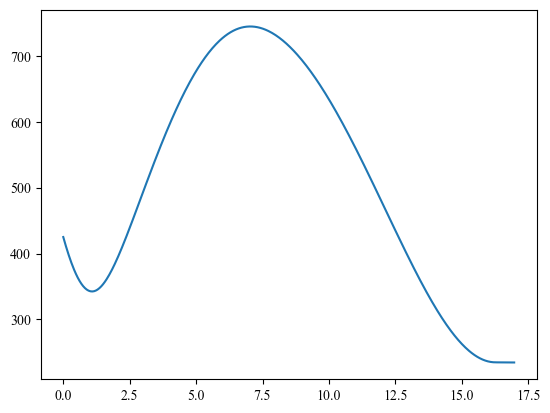

In [339]:
sep = r1_sol - r2_sol
sep_mag = np.linalg.norm(sep, axis=1)
print(sep_mag)

plt.plot(time_values, sep_mag, label="Separation")

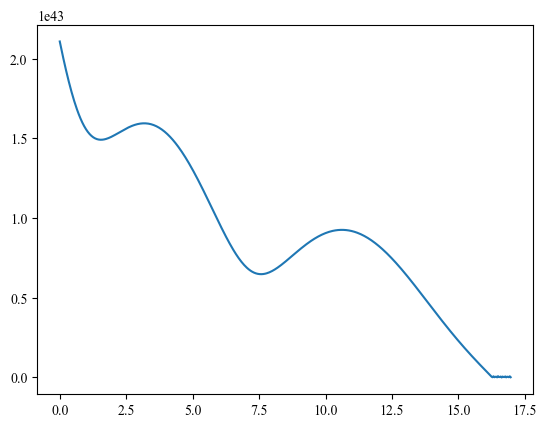

In [340]:
pos_mag = np.linalg.norm(r1_sol, axis=1)
vel_mag = np.linalg.norm(v1_sol, axis=1)
ang_mom = m1 * (pos_mag * vel_mag) 
plt.plot(time_values, ang_mom, label="Angular Momentum")


[[-7.21029368e+01  1.01687491e+02  0.00000000e+00]
 [-7.21978999e+01  1.01365139e+02  0.00000000e+00]
 [-7.22848614e+01  1.01032973e+02  0.00000000e+00]
 ...
 [-1.29567393e-01  1.18773436e-01  0.00000000e+00]
 [ 6.01041940e-01 -5.19943183e-01  0.00000000e+00]
 [ 1.44125015e-01 -1.01112394e-01  0.00000000e+00]]


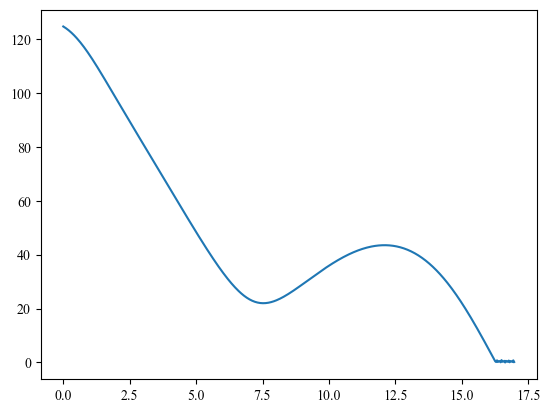

In [341]:

v1_mag = np.linalg.norm(v1_sol, axis=1)
print(v1_sol)

plt.plot(time_values, v1_mag, label="Magnitude of V1")

[[212.49282128   3.53589915   0.        ]
 [209.98234048   7.06058941   0.        ]
 [207.46883584  10.57372953   0.        ]
 ...
 [-96.05322399  67.43229403   0.        ]
 [-96.03232443  67.41421445   0.        ]
 [-96.02731289  67.41069855   0.        ]]


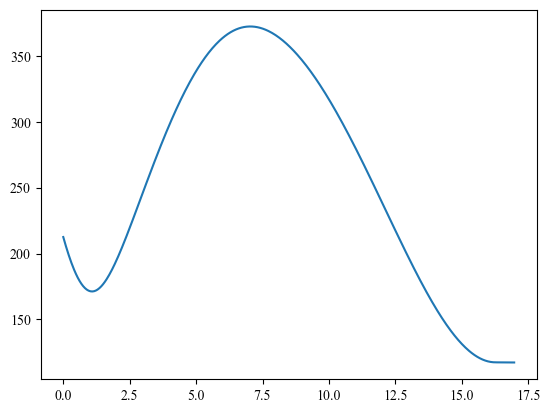

In [342]:

r1_mag = np.linalg.norm(r1_sol, axis=1)
print(r1_sol)

plt.plot(time_values, r1_mag, label="Magnitude of R1")

[2.88092316e+29 2.92631026e+29 2.97165663e+29 3.01688000e+29
 3.06189336e+29 3.10660514e+29 3.15091951e+29 3.19473667e+29
 3.23795326e+29 3.28046288e+29 3.32215659e+29 3.36292354e+29
 3.40265168e+29 3.44122847e+29 3.47854173e+29 3.51448045e+29
 3.54893569e+29 3.58180152e+29 3.61297587e+29 3.64236151e+29
 3.66986691e+29 3.69540710e+29 3.71890448e+29 3.74028958e+29
 3.75950167e+29 3.77648939e+29 3.79121114e+29 3.80363552e+29
 3.81374148e+29 3.82151848e+29 3.82696647e+29 3.83009577e+29
 3.83092681e+29 3.82948977e+29 3.82582417e+29 3.81997826e+29
 3.81200846e+29 3.80197864e+29 3.78995939e+29 3.77602726e+29
 3.76026393e+29 3.74275544e+29 3.72359136e+29 3.70286399e+29
 3.68066762e+29 3.65709777e+29 3.63225051e+29 3.60622181e+29
 3.57910690e+29 3.55099980e+29 3.52199277e+29 3.49217592e+29
 3.46163682e+29 3.43046016e+29 3.39872756e+29 3.36651726e+29
 3.33390403e+29 3.30095905e+29 3.26774977e+29 3.23433993e+29
 3.20078955e+29 3.16715491e+29 3.13348863e+29 3.09983976e+29
 3.06625381e+29 3.032772

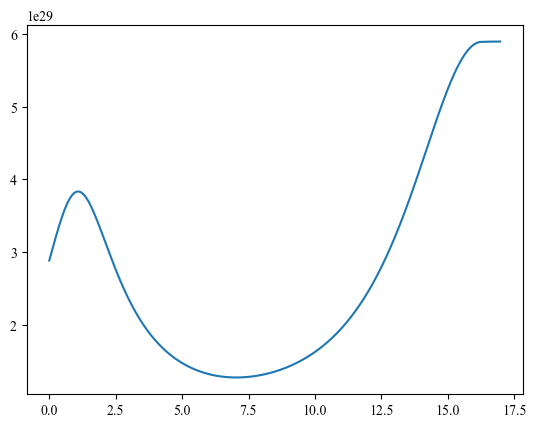

In [343]:
df1_mag = np.linalg.norm(F_force1, axis=1)
print(df1_mag)

plt.plot(time_values, df1_mag, label="Magnitude of Dynamical Friction Force 1")

In [344]:
r1_sol = np.array(r1_sol)
r2_sol = np.array(r2_sol)



finalsep = r1_sol[-1] - r2_sol[-1]

print(finalsep)

[-192.05462577  134.8213971     0.        ]


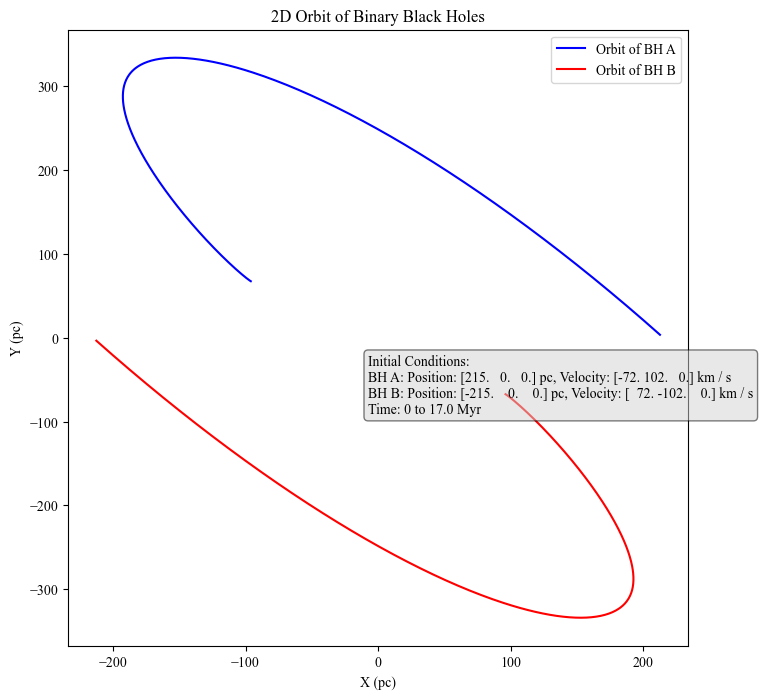

In [345]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)  # No projection='3d' for 2D plot

# Plot the orbits in 2D (X and Y dimensions)
ax.plot(r1_sol[:, 0], r1_sol[:, 1], label="Orbit of BH A", color="blue")
ax.plot(r2_sol[:, 0], r2_sol[:, 1], label="Orbit of BH B", color="red")

# Set labels and title
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_title('2D Orbit of Binary Black Holes')

# Add a legend
ax.legend()

# Add initial conditions as text
initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position: {r1_initial}, Velocity: {v1_initial}\n"
    f"BH B: Position: {r2_initial}, Velocity: {v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0.5, 0.4, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# Show the plot
plt.show()

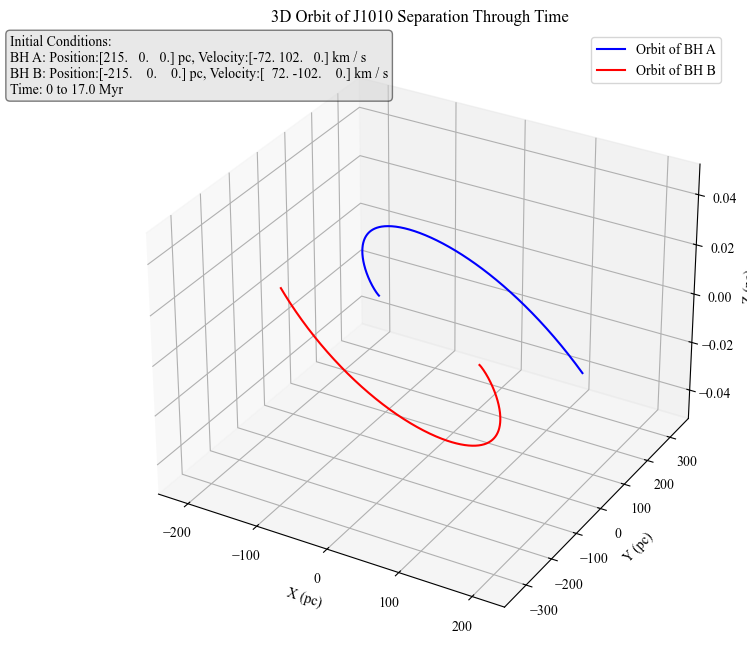

In [346]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:, 2], label="Orbit of BH A", color="blue")


ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:, 2], label="Orbit of BH B", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)') 
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit of J1010 Separation Through Time')


ax.legend()

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

plt.show()

In [347]:
r2_sol[-2]

array([ 96.03232443, -67.41421445,   0.        ])

In [348]:
sep = r2_sol[-2] - r1_sol[-2]
sep_magnitude = np.linalg.norm(sep)
print(r1_sol[-1], sep_magnitude)


[-96.02731289  67.41069855   0.        ] 234.66472803561192


/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_10544/682720306.py:24: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


Text(0, 0.8, 'Initial Conditions:\nBH A: Position:[215.   0.   0.] pc, Velocity:[-72. 102.   0.] km / s\nBH B: Position:[-215.    0.    0.] pc, Velocity:[  72. -102.    0.] km / s\nTime: 0 to 17.0 Myr')

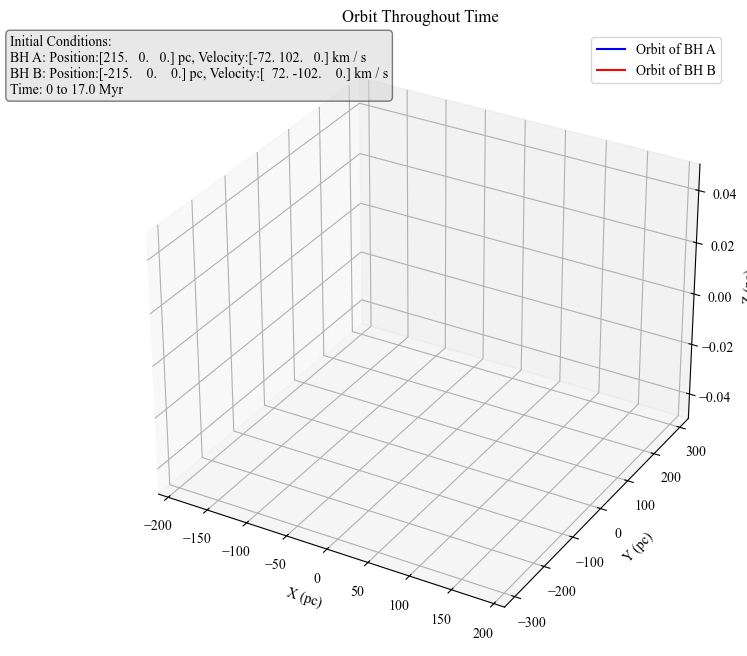

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('Orbit Throughout Time')


line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
ax.legend()

# Limits for the plot (adjust as needed based on data)
ax.set_xlim([min(np.min(r1_sol[:, 0]), np.min(r2_sol[:, 0])), max(np.max(r1_sol[:, 0]), np.max(r2_sol[:, 0]))])
ax.set_ylim([min(np.min(r1_sol[:, 1]), np.min(r2_sol[:, 1])), max(np.max(r1_sol[:, 1]), np.max(r2_sol[:, 1]))])
ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


def update(num):

    line1.set_data(r1_sol[:num, 0], r1_sol[:num, 1])
    line1.set_3d_properties(r1_sol[:num, 2])
    
    line2.set_data(r2_sol[:num, 0], r2_sol[:num, 1])
    line2.set_3d_properties(r2_sol[:num, 2])
    
    return line1, line2

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# ani = FuncAnimation(fig, update, frames=len(r1_sol), interval=50, blit=True)


# plt.show()


# ani.save("J1010#6.mp4", writer="ffmpeg", fps=220)  # Adjust fps as needed

Plot of Velocities

In [350]:
F_D1sol.shape

(500, 3)

Dynamical Friction Plot

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

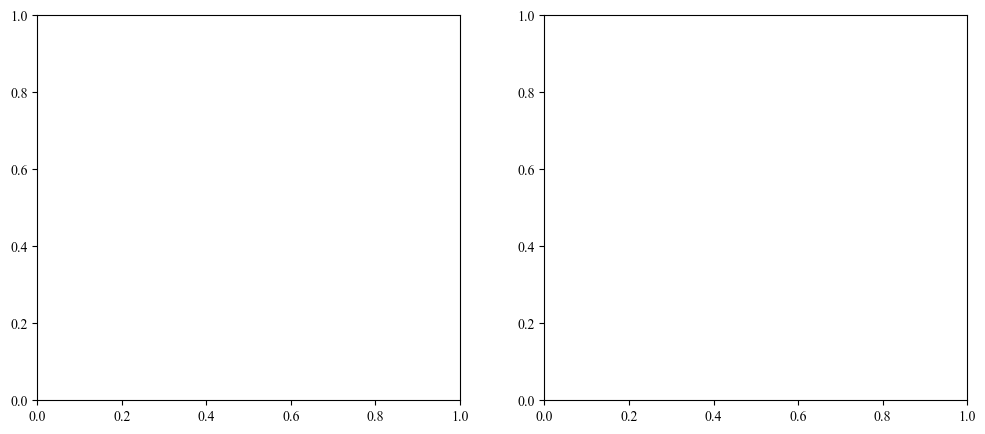

In [351]:
c_values = [0.001, 0.01, 0.1, 1, 10, 100]  

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

for c in c_values:
    r1_sol = []
    r2_sol = []
    v1_sol = []
    v2_sol = []
    F_D1sol = []
    F_D2sol = []


    for i in range(N):
        dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D1)
        dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D2) 
        v1 += dv1bydt * delta_t
        v2 += dv2bydt * delta_t

        r1 += v1.to(u.pc / u.s) * delta_t
        r2 += v2.to(u.pc / u.s) * delta_t
        # region Code Snippet 2: DF
        r1_com = r1 - r_com
        r2_com = r2 - r_com

        r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
        r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
        

        o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
        # region code : Coulomb Logarithm
        x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
        x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
        ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
        ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
        # endregion

        F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
        F_D2 = 0.428 * ln_A2 * ((G * m2**(2))/r2_com**(2))


        v_r1 = v1 - v_com 
        v_r2 = v2 - v_com

        v_rmag1 = np.sqrt(v_r1[0]**2 + v_r1[1]**2 + v_r1[2]**2)
        v_rmag2 = np.sqrt(v_r2[0]**2 + v_r2[1]**2 + v_r2[2]**2) #will be doing this from now on though linalg.norm does the same

        v_rel_unit1 = (v_r1 / v_rmag1)
        v_rel_unit2 = (v_r2 / v_rmag2)

        # region code: Dynamical Friction Component to Array for BH A
        F_D1_i = (F_D1 * -v_rel_unit1[0])
        F_D1_j = (F_D1 * -v_rel_unit1[1])
        F_D1_k = (F_D1 * -v_rel_unit1[2])
            
        F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
        # endregion

        # region code: Dynamical Friction Component to Array for BH B
        F_D2_i = (F_D2 * -v_rel_unit2[0])
        F_D2_j = (F_D2 * -v_rel_unit2[1])
        F_D2_k = (F_D2 * -v_rel_unit2[2])
            
        F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
        # endregion


        F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
        F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))
            

        F_D1 = (F_D1 / m1).to(u.km / u.s**2)
        F_D2 = (F_D2 / m2).to(u.km / u.s**2)
        F_D1sol.append([

            (F_D1_i.to((u.kg * u.m) / (u.s**2))/m1).value,
            (F_D1_j.to((u.kg * u.m) / (u.s**2))/m1).value,
            (F_D1_k.to((u.kg * u.m) / (u.s**2))/m1).value
        ])
        F_D2sol.append([

            (F_D2_i.to((u.kg * u.m) / (u.s**2))/m2).value,
            (F_D2_j.to((u.kg * u.m) / (u.s**2))/m2).value,
            (F_D2_k.to((u.kg * u.m) / (u.s**2))/m2).value
        ])

        r1_sol.append(r1.copy())
        r2_sol.append(r2.copy())
        v1_sol.append(v1.copy())
        v2_sol.append(v2.copy())


    F_D1sol = np.array(F_D1sol)
    F_D2sol = np.array(F_D2sol)


    mag_fd1 = np.sqrt(F_D1sol[:, 0]**2 + F_D1sol[:, 1]**2 + F_D1sol[:, 2]**2)
    mag_fd2 = np.sqrt(F_D2sol[:, 0]**2 + F_D2sol[:, 1]**2 + F_D2sol[:, 2]**2)


    axs[0].plot(time_values, mag_fd1, label=f"c = {c}")
    axs[1].plot(time_values, mag_fd2, label=f"c = {c}")


axs[0].set_title("Dynamical Friction - Body 1")
axs[0].set_xlabel("Time (Myr)")
axs[0].set_ylabel("Force Magnitude (km/s²)")
axs[0].legend()

axs[1].set_title("Dynamical Friction - Body 2")
axs[1].set_xlabel("Time (Myr)")
axs[1].set_ylabel("Force Magnitude (km/s²)")
axs[1].legend()

plt.tight_layout()
plt.show()

Testing separation levels here

In [ ]:
massterm = (m1+m2)/(10**8*u.Msun)
velterm = ((200*u.km/u.s)/o)**2
dynhard_rad = (10*u.pc*massterm*velterm).to(u.pc)
print(dynhard_rad) #this is the semi-major axis for when stellar hardening takes over from DF (so sep/2)

81.5361082035837 pc


In [ ]:
r1_sol[-1]

array([-128.45484985,  207.05985781,    0.        ])

In [ ]:
r1_sol[0]

array([2.14999999e+02, 3.24645701e-02, 0.00000000e+00])